In [57]:
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import confusion_matrix, accuracy_score, silhouette_score
from sklearn.pipeline import Pipeline

%precision 4


'%.4f'

# Clustering

## Curse of dimensionality

### Sparsity

As the number of dimensions increases, data becomes increasingly sparse: the probability of finding points away from the boundaries approaches zero. Consider uniformly distributed random variables on the [0, 1] interval. If we define "internal points" as those not within 2% of the extremes (i.e., points in [0.02, 0.98]):

- In 1 dimension: The probability of sampling an internal point is 0.98 - 0.02 = 0.96 (96%)
- In 2 dimensions: The probability becomes 0.96² = 0.92 (92%)
- In 3 dimensions: The probability further reduces to 0.96³ = 0.88 (88%)

This pattern continues multiplicatively with each additional dimension. By induction, in a 100-dimensional space, the probability of sampling an internal point falls to 0.96¹⁰⁰ ≈ 0.017 (less than 2%).
This means that in high-dimensional spaces, almost all points lie near the boundaries of the space—a counterintuitive property that makes statistical sampling, clustering, and distance-based algorithms increasingly challenging as dimensionality grows.

### Distance metrics in high-dimensional spaces gets useless

As the dimensionality increases, the average distance from a random point to other points in the dataset obviously grows. However, somewhat counterintuitively, the ratio between the distance to the nearest point and the distance to the farthest point converges toward 1. This means that in very high dimensions, all points become almost equidistant from each other. This concentration of distances undermines the fundamental assumption of many clustering algorithms that nearby points should be more similar than distant ones.

Let's run a simulation to see how this works. (I did not use prng here as reproducibility is not an issue here.)

In [58]:
def generate_random_dataset(num_points, num_dimensions):
    # Generate random points uniformly distributed in [0, 1]^n
    return np.random.rand(num_points, num_dimensions)

def calculate_distances(dataset, query_point):
    # calculate Euclidean distances in an efficient way
    return np.linalg.norm(dataset - query_point, axis=1)

def run_experiment(dimensions, num_points=10000):
    min_distances = []
    max_distances = []
    
    for dim in dimensions:
        # Generate a random dataset and a query point
        dataset = generate_random_dataset(num_points, dim)
        
        # define a query point
        query_point = np.random.rand(1, dim)
        
        # Calculate distances from the query point
        distances = calculate_distances(dataset, query_point)
        
        # Record the min and max distances
        min_distances.append(np.min(distances))
        max_distances.append(np.max(distances))

    return {'min_distances': min_distances, 'max_distances': max_distances}
    

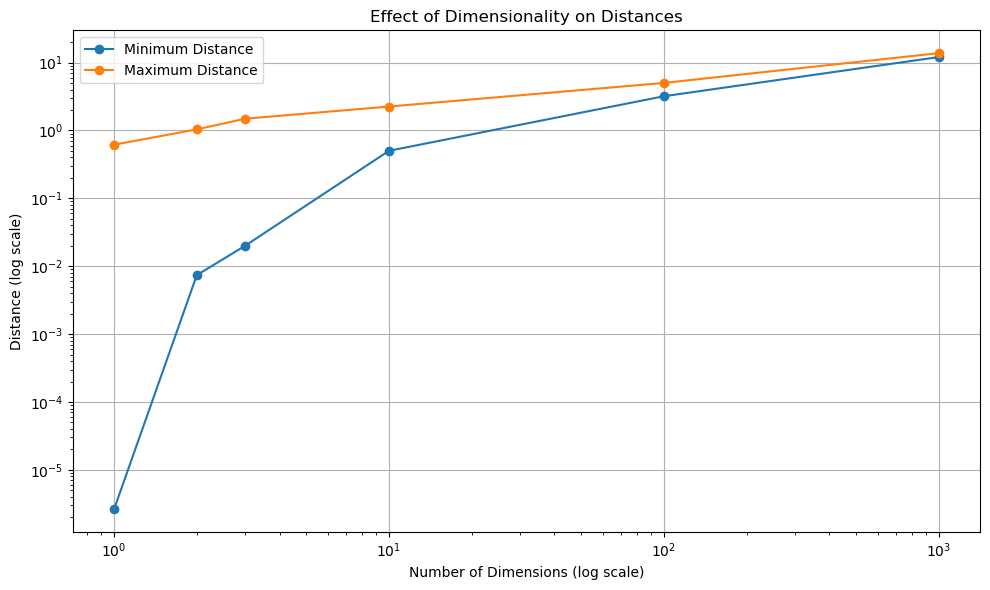

In [ ]:
# Run the experiment
dimensions = [1, 2, 3, 10, 100, 1000]
results = run_experiment(dimensions=dimensions)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(dimensions, results['min_distances'], label='Minimum Distance', marker='o')
plt.plot(dimensions, results['max_distances'], label='Maximum Distance', marker='o')
plt.xlabel("Number of Dimensions (log scale)")
plt.ylabel("Distance (log scale)")
plt.title("Effect of Dimensionality on Distances")
plt.legend()
plt.grid(True)
plt.xscale('log')  # Use log scale for better visualization
plt.yscale('log')
plt.tight_layout()


## KMeans on the wine dataset

Let's use the wine dataset from the previous class.

In [60]:
prng = np.random.RandomState(20250310)

X, y = load_wine(return_X_y=True, as_frame=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=prng
)

In [61]:
# KMeans
kmeans = KMeans(n_clusters=3, random_state=prng) # define the model
kmeans.fit(X_train) # fit the model

KMeans(n_clusters=3, random_state=RandomState(MT19937) at 0x168FDCC40)

In [62]:
kmeans.cluster_centers_.shape

(3, 13)

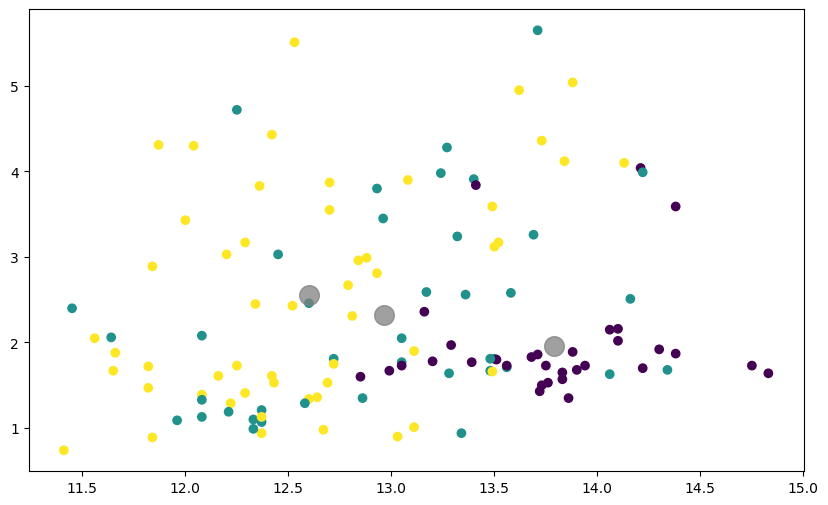

In [ ]:
# plot the results
plt.figure(figsize=(10, 6))
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=kmeans.labels_, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='gray', s=200, alpha=0.75)

### KMeans with PCA (after scaling)

In [64]:
scaler = StandardScaler()
scaler.set_output(transform='pandas')
scaled_X_train = scaler.fit_transform(X_train)
pca = PCA(n_components=2)
scaled_X_train_pca = pca.fit_transform(scaled_X_train)


In [65]:
kmeans_pc12 = KMeans(n_clusters=3, random_state=prng).fit(scaled_X_train_pca)

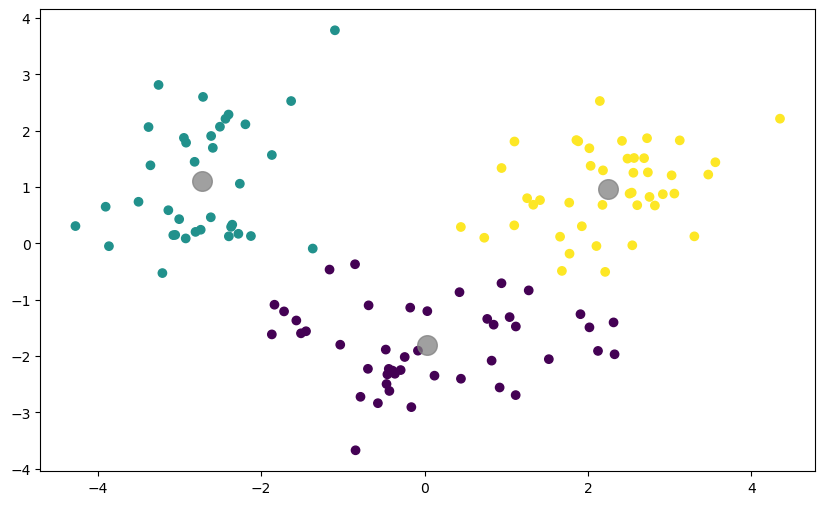

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(scaled_X_train_pca[:, 0], scaled_X_train_pca[:, 1], c=kmeans_pc12.labels_, cmap='viridis')
plt.scatter(kmeans_pc12.cluster_centers_[:, 0], kmeans_pc12.cluster_centers_[:, 1], c='gray', s=200, alpha=0.75)

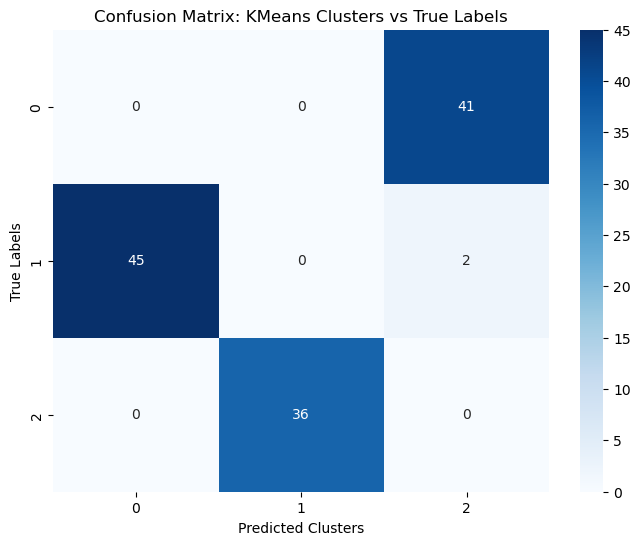

In [ ]:
# Create confusion matrix between kmeans labels and true labels
def plotConfusionMatrix(true_y, kmeans_labels):
    conf_matrix = confusion_matrix(true_y, kmeans_labels)

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix: KMeans Clusters vs True Labels")
    plt.xlabel("Predicted Clusters")
    plt.ylabel("True Labels")

plotConfusionMatrix(y_train, kmeans_pc12.labels_)

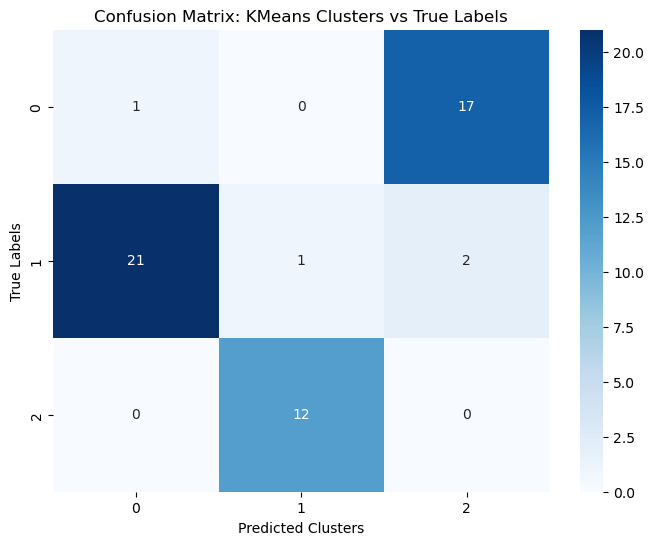

In [68]:
plotConfusionMatrix(y_test, kmeans_pc12.predict(pca.transform(scaler.transform(X_test))))

### Technical detour: Pipeline

When evaluating our model on a new dataset, we must apply the same transformations used on the training set (e.g., scaling, projecting onto PC1 & PC2). Doing this manually can quickly become tedious and error-prone. Fortunately, sklearn provides a convenient solution: Pipeline.

A Pipeline streamlines preprocessing by defining a sequence of transformations once and applying them consistently to any dataset. It consists of a list of steps, where each step is a two-element tuple: a name (which you choose) and the corresponding operation. The steps are executed sequentially, ensuring a structured and reproducible workflow.

In [69]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('pca', PCA(n_components=2)),
    ('kmeans', KMeans(n_clusters=3, random_state=prng))
])
pipeline

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('kmeans',
                 KMeans(n_clusters=3,
                        random_state=RandomState(MT19937) at 0x168FDCC40))])

In [70]:
pipeline.fit(X_train)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=2)),
                ('kmeans',
                 KMeans(n_clusters=3,
                        random_state=RandomState(MT19937) at 0x168FDCC40))])

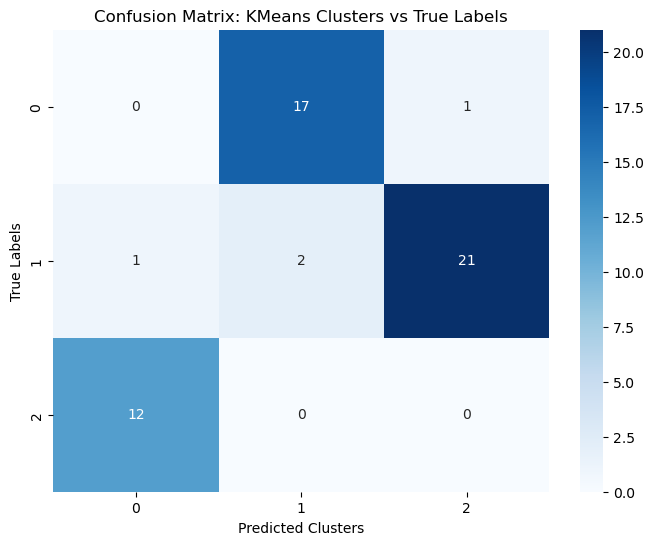

In [71]:
plotConfusionMatrix(y_test, pipeline.predict(X_test))

### Evaluate the segments

In [131]:
# Calculate accuracy
# Create mapping dictionary to relabel clusters for consolidation
label_mapping = {0: 1, 1: 2, 2: 0}

# Apply mapping to kmeans labels
def relabel_clusters(labels, mapping):
    return np.array([mapping[label] for label in labels])

# Compute accuracy
def cluster_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

accuracy = cluster_accuracy(y_train, relabel_clusters(kmeans_pc12.labels_, label_mapping))
print(f"Clustering Accuracy: {accuracy:.2%}")


Clustering Accuracy: 98.39%


*Question:* What is the difference between this exercise and a standard classification problem?

<details>
<summary>Answer</summary>

In a standard classification problem, we have a dataset with both features and labels. We use the features to predict the labels, which is why it's called supervised learning—the algorithm is 'supervised' by known correct answers during training.

In this clustering exercise, we use only the features to group the data into different clusters without using their actual labels—making it an unsupervised learning approach. The algorithm must discover patterns and structure in the data without guidance from known outcomes.

The key difference is that in classification, we explicitly train a model to map features to known labels, while in clustering, we seek to identify natural groupings based solely on feature similarity. Only after clustering do we examine how well these discovered groups align with the known wine classes.

This exercise illustrates the power of unsupervised learning for segmentation and pattern discovery in scenarios where labeled data may be unavailable, expensive to obtain, or when we want to discover novel patterns that might not align with predetermined categories.

</details>

### What if we don't know the number of clusters?

We can use two clustering metrics to help us determine the optimal number of clusters:

1. **Inertia** is a measure of how internally coherent clusters are. Specifically, it's the sum of squared distances between each point and its assigned cluster centroid.

    - Lower inertia values indicate more compact, well-defined clusters
    - Inertia always decreases as the number of clusters increases -- we need to use the 'elbow' method to find the optimal number of clusters
    - It's sensitive to scale and doesn't handle differently sized clusters well

2. **Silhouette Score** measures how similar points are to their own cluster compared to other clusters. It's a more sophisticated metric that accounts for both the compactness of clusters and their separation from other clusters.

    - Higher silhouette scores indicate better-defined clusters
    - Silhouette score ranges from -1 to 1, where 1 is the best possible score
    - It's less sensitive to scale and can handle differently sized clusters better

In [73]:
pipeline['kmeans'].inertia_

184.1369

In [74]:
data_used_for_clustering = pipeline['pca'].transform(pipeline['scaler'].transform(X_train))
data_used_for_clustering = pipeline[:-1].transform(X_train)  # run the pipline up until the last step

silhouette_score(data_used_for_clustering, pipeline['kmeans'].labels_)

0.5613

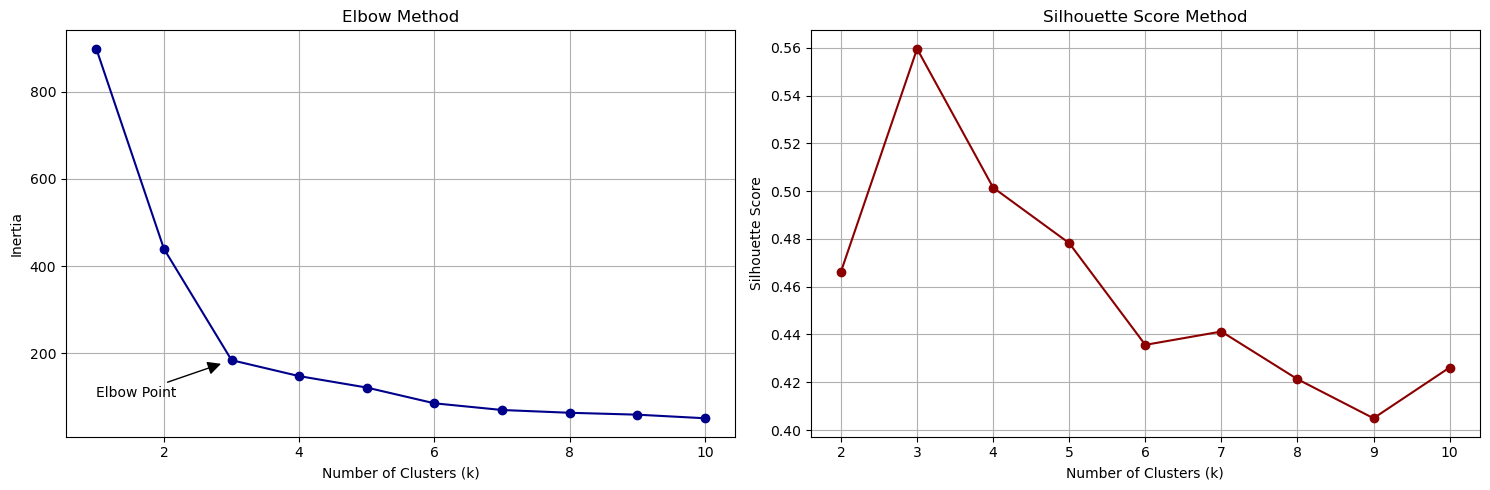

In [118]:
# Try different numbers of clusters and calculate inertia & silhouette score
inertias = []
silhouette_scores = []
n_clusters_range = range(1, 11)

for n_clusters in n_clusters_range:
    # Create and fit pipeline with different number of clusters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=2)),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=prng))
    ])
    
    pipeline.fit(X_train)
    
    # Get inertia
    inertias.append(pipeline['kmeans'].inertia_)
    
    # Calculate silhouette score for n_clusters > 1
    if n_clusters > 1:
        silhouette_scores.append(silhouette_score(pipeline[:-1].transform(X_train), pipeline['kmeans'].labels_))

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Inertia plot
ax1.plot(n_clusters_range, inertias, marker='o', color='darkblue')
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.set_title("Elbow Method")
ax1.grid(True)

ax1.annotate(
    "Elbow Point", 
    xy=(3, inertias[2]), xytext=(1, 100),
    arrowprops=dict(arrowstyle='-|>', shrinkA=2, shrinkB=8, facecolor='black', mutation_scale=20), fontsize=10
)

# Silhouette score plot
ax2.plot(list(n_clusters_range)[1:], silhouette_scores, marker='o', color='darkred')
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")
ax2.grid(True)

plt.tight_layout()
plt.show()


So far, we created clusters based on the first two principal components only. However, we can use all the data without applying PCA. The predicted clusters nicely match with the previous results.

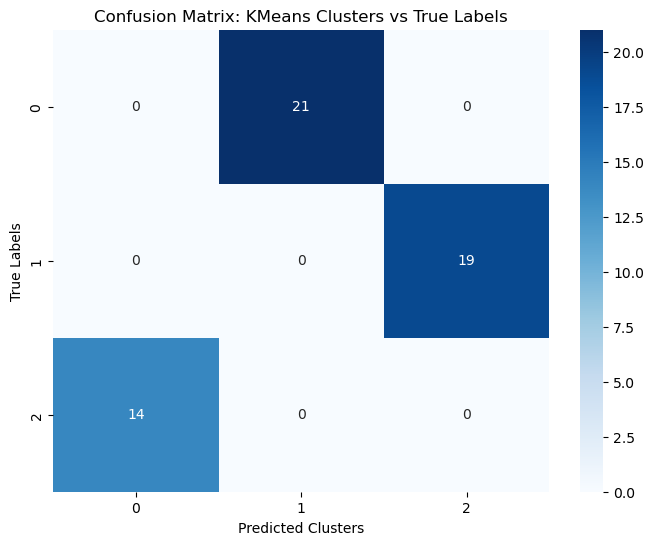

In [128]:
# Run KMeans on all the data for 3 clusters
pipeline_without_pca = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=prng))
])
pipeline_without_pca.fit(X_train)

# Compare predictions
plotConfusionMatrix(pipeline.predict(X_test), pipeline_without_pca.predict(X_test))

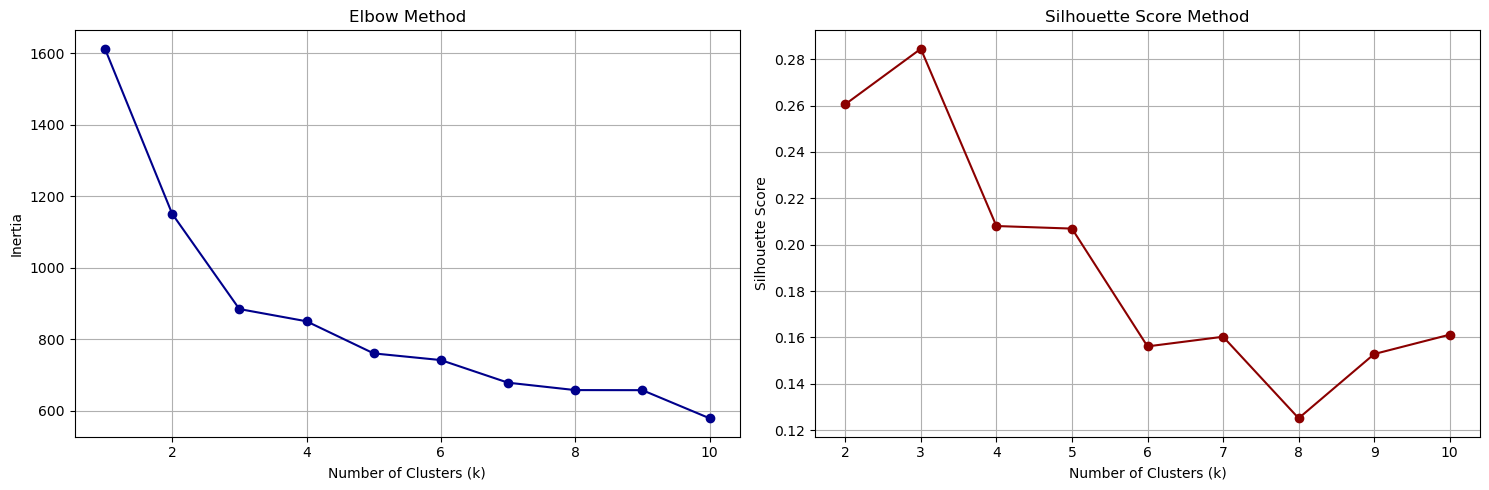

In [120]:
# Try different numbers of clusters and calculate inertia & silhouette score
inertias = []
silhouette_scores = []
n_clusters_range = range(1, 11)

for n_clusters in n_clusters_range:
    # Create and fit pipeline with different number of clusters
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('kmeans', KMeans(n_clusters=n_clusters, random_state=prng))
    ])
    
    pipeline.fit(X_train)
    
    # Get inertia
    inertias.append(pipeline['kmeans'].inertia_)
    
    # Calculate silhouette score for n_clusters > 1
    if n_clusters > 1:
        silhouette_scores.append(silhouette_score(pipeline[:-1].transform(X_train), pipeline['kmeans'].labels_))

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Inertia plot
ax1.plot(n_clusters_range, inertias, marker='o', color='darkblue')
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia")
ax1.set_title("Elbow Method")
ax1.grid(True)

# Silhouette score plot
ax2.plot(list(n_clusters_range)[1:], silhouette_scores, marker='o', color='darkred')
ax2.set_xlabel("Number of Clusters (k)")
ax2.set_ylabel("Silhouette Score")
ax2.set_title("Silhouette Score Method")
ax2.grid(True)

plt.tight_layout()
plt.show()

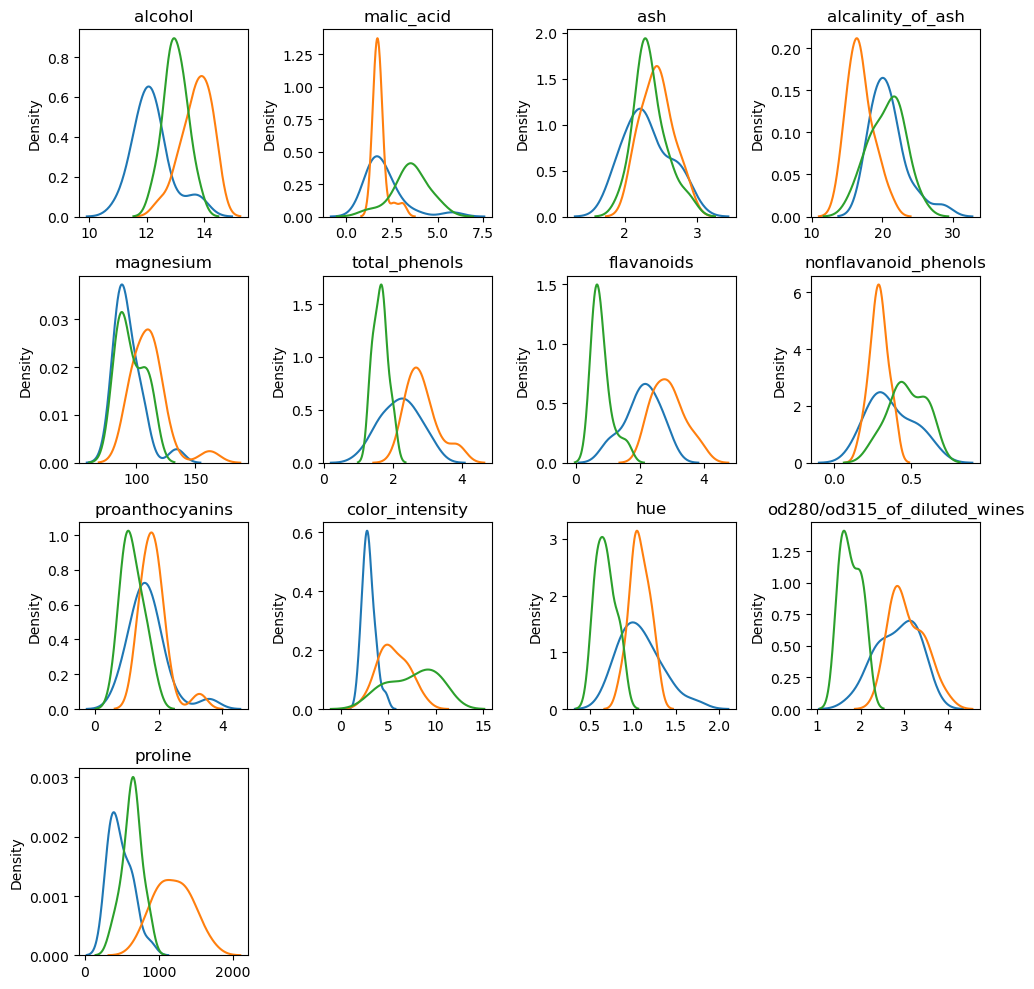

In [127]:
# Create and fit pipeline with 3 clusters on training data
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_clusters=3, random_state=prng))
])

pipeline.fit(X_train)

# Get predictions on test data
y_pred = pipeline.predict(X_test)

# Create figure with subplots for each feature
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.ravel()  # Flatten axes array for easier indexing



# Plot distribution for each feature
for i, feature in enumerate(X_test.columns):
    for cluster in range(3):
        sns.kdeplot(
            data=X_test[feature][y_pred == cluster],
            ax=axes[i],
            label=f"Cluster {cluster}"
        )
    axes[i].set_title(f"{feature}")
    axes[i].set_xlabel("")

# Remove any empty subplots
for i in range(13, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Kmeans on another dataset

## DBSCAN on the other dataset (TO CHECK!!!)

Dataset shape: (440, 8)
Features: ['Channel', 'Region', 'Fresh', 'Milk', 'Grocery', 'Frozen', 'Detergents_Paper', 'Delicassen']
Missing values: 0
Explained variance ratio: [0.3875 0.2237 0.1265]
Total explained variance: 0.7377
Number of clusters found by DBSCAN: 6
Number of noise points: 81 (18.4% of data)
K-means silhouette score: 0.357
DBSCAN silhouette score: 0.27538363238094427


/Users/divenyijanos/teaching/ceu-ml/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/divenyijanos/teaching/ceu-ml/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/tq/b54ndxkd5d940lj3pfrg49lh0000gn/T/ipykernel_35765/585073527.py:96: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', n_clusters)


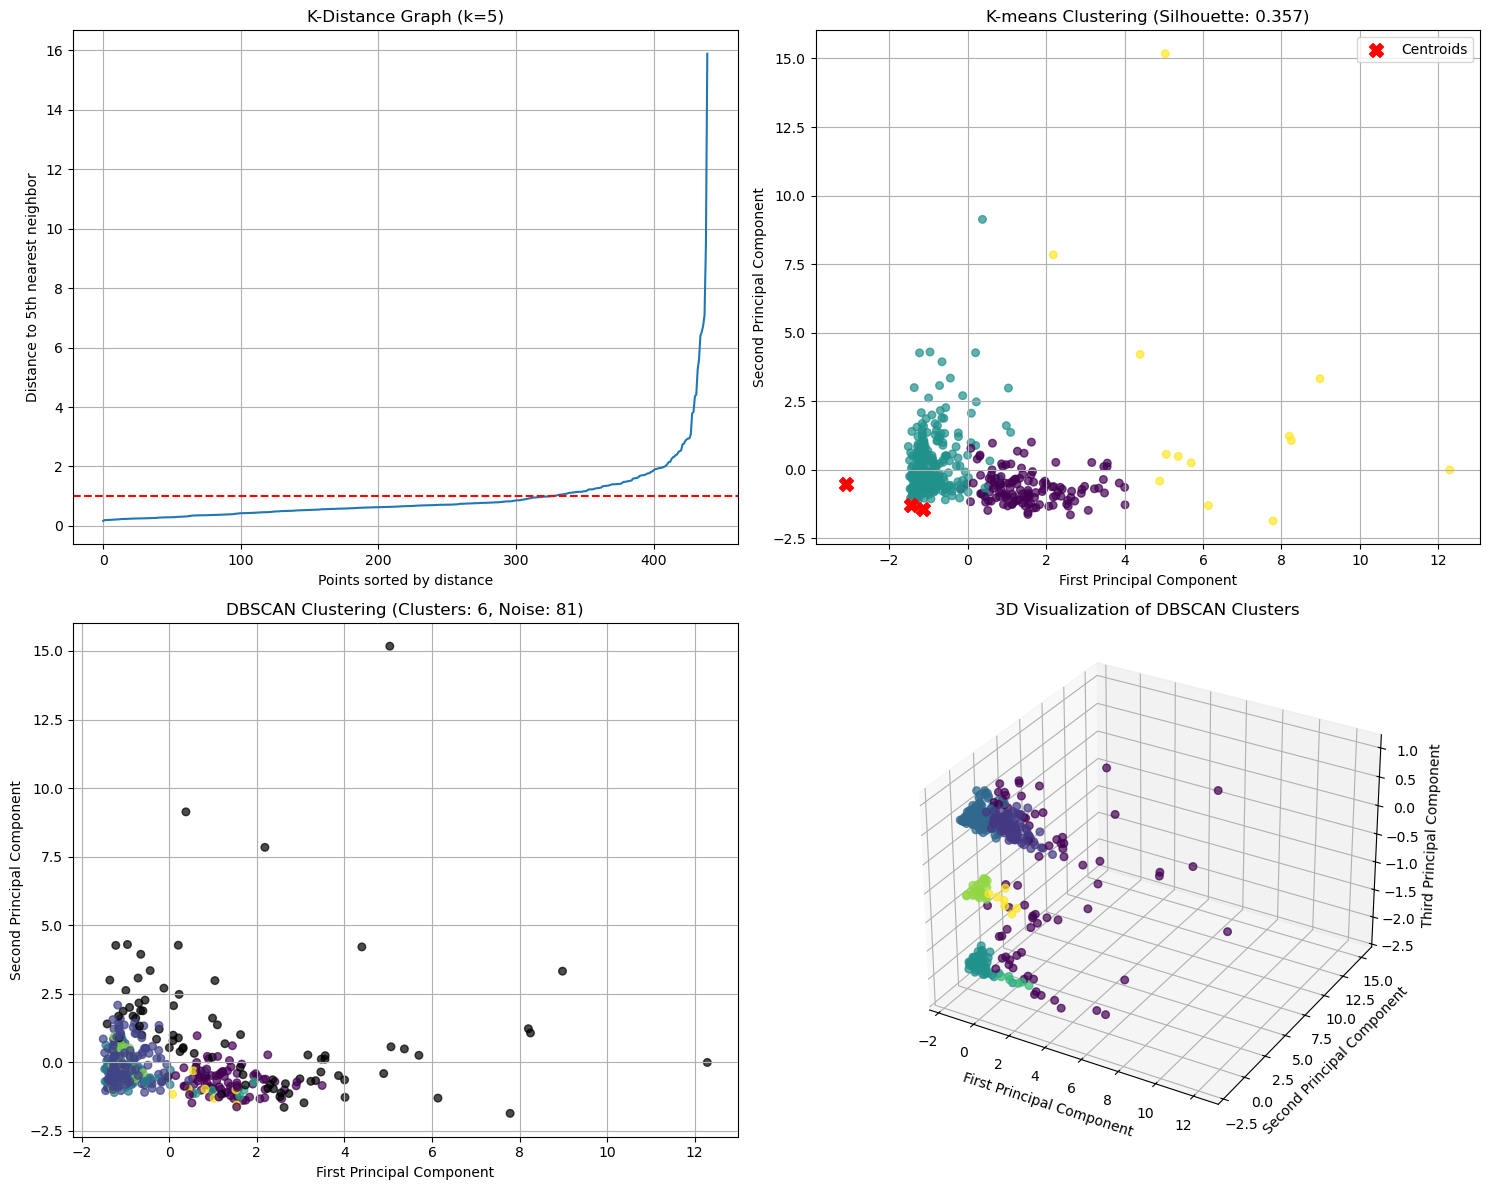


K-means Cluster Analysis:
     Cluster  Size  Percentage  Channel  Region    Fresh     Milk  Grocery  \
0  Cluster 0   130        29.5      2.0     2.6   8165.9   8748.5  13905.5   
1  Cluster 1   297        67.5      1.0     2.5  13075.9   3218.7   3855.7   
2  Cluster 2    13         3.0      1.8     2.6  25770.8  35160.4  41977.4   

   Frozen  Detergents_Paper  Delicassen  
0  1441.6            5991.1      1535.0  
1  3620.4             776.9      1242.2  
2  6844.5           19867.4      7880.3  

DBSCAN Cluster Analysis:
     Cluster  Size  Percentage  Channel  Region    Fresh     Milk  Grocery  \
0      Noise    81        18.4      1.6     2.3  20439.5  13867.9  17811.8   
1  Cluster 0    83        18.9      2.0     3.0   8162.3   7760.2  12315.9   
2  Cluster 1   187        42.5      1.0     3.0  11296.5   2733.0   3313.8   
3  Cluster 2    50        11.4      1.0     1.0   9614.3   2890.4   3349.2   
4  Cluster 3     6         1.4      2.0     1.0   2006.2   7330.2  13231.2  

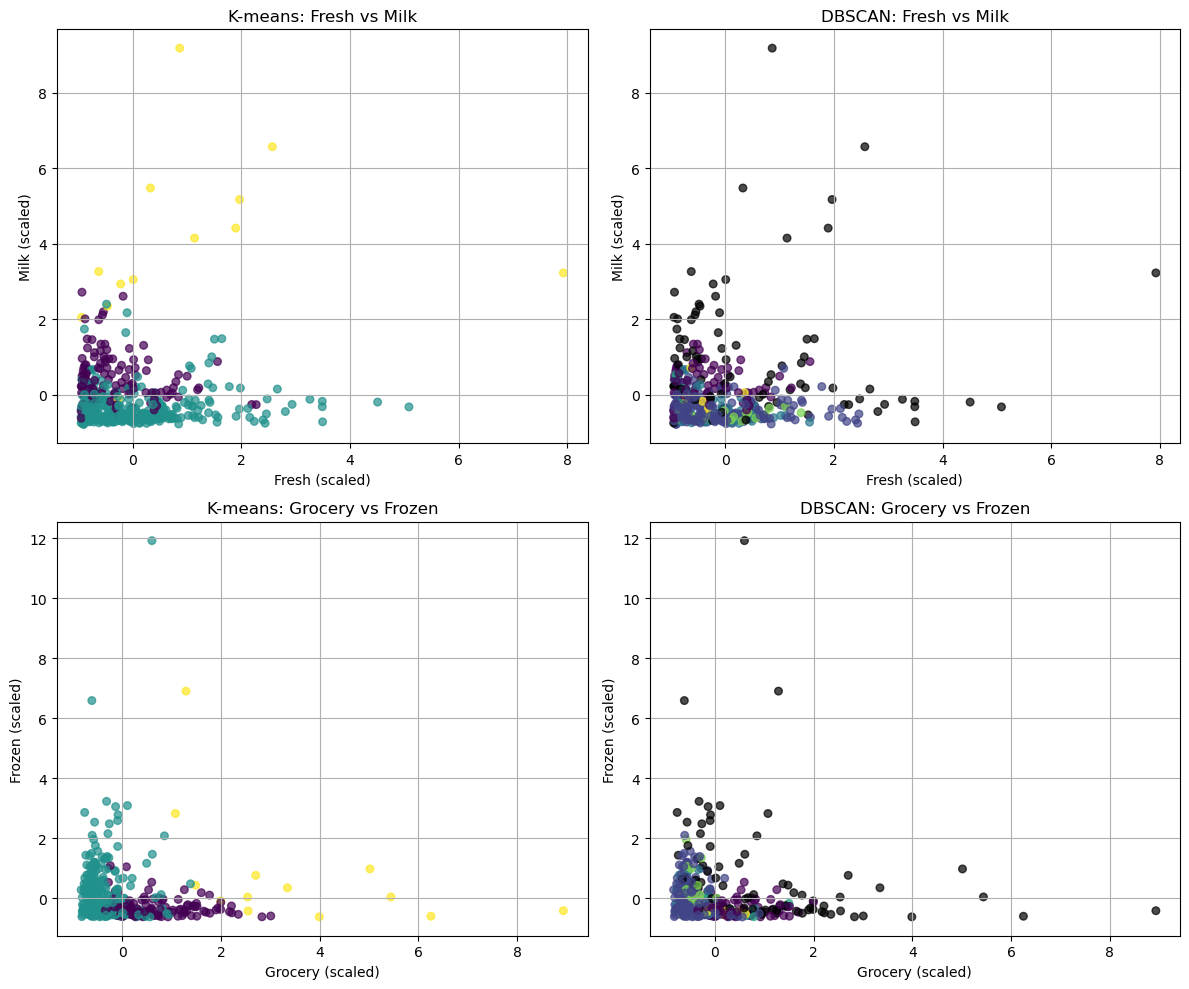

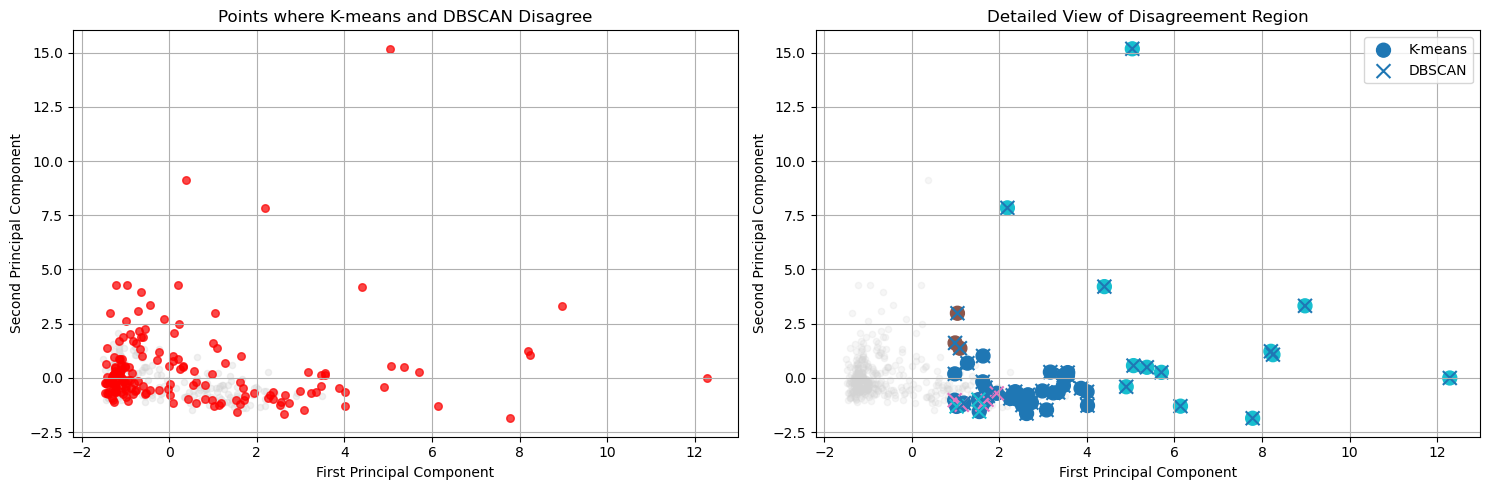

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors

# Load the Wholesale Customer dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00292/Wholesale%20customers%20data.csv'
try:
    data = pd.read_csv(url)
except:
    # If the URL fails, use this alternative loading method
    from sklearn.datasets import fetch_openml
    data = fetch_openml(name='Wholesale-customers', version=1, as_frame=True)
    data = data['data']

# Print basic information about the dataset
print('Dataset shape:', data.shape)
print('Features:', data.columns.tolist())

# Check for missing values
print('Missing values:', data.isnull().sum().sum())

# Scale the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=3)
data_pca = pca.fit_transform(data_scaled)

# Explained variance
print(f'Explained variance ratio: {pca.explained_variance_ratio_}')
print(f'Total explained variance: {sum(pca.explained_variance_ratio_):.4f}')

# Create a figure with multiple plots
plt.figure(figsize=(15, 12))

# 1. Find optimal eps for DBSCAN using k-distance graph
k = 5
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(data_scaled)
distances, indices = nbrs.kneighbors(data_scaled)
distances = np.sort(distances[:, k-1])

plt.subplot(2, 2, 1)
plt.plot(distances)
plt.axhline(y=1.0, color='r', linestyle='--')  # Example threshold
plt.title(f'K-Distance Graph (k={k})')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {k}th nearest neighbor')
plt.grid(True)

# 2. Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)
kmeans_silhouette = silhouette_score(data_scaled, kmeans_labels)

# 3. Perform DBSCAN clustering
# Choose eps based on the k-distance graph (around the 'elbow')
dbscan = DBSCAN(eps=1.0, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

# Calculate silhouette score for DBSCAN (excluding noise points)
non_noise_mask = dbscan_labels != -1
if len(set(dbscan_labels[non_noise_mask])) > 1:  # Need at least 2 clusters for silhouette
    dbscan_silhouette = silhouette_score(data_scaled[non_noise_mask], dbscan_labels[non_noise_mask])
else:
    dbscan_silhouette = 'N/A (not enough valid clusters)'

print(f'Number of clusters found by DBSCAN: {n_clusters}')
print(f'Number of noise points: {n_noise} ({n_noise/len(data_scaled):.1%} of data)')
print(f'K-means silhouette score: {kmeans_silhouette:.3f}')
print(f'DBSCAN silhouette score: {dbscan_silhouette}')

# 4. Visualize the first two principal components with both clustering methods
plt.subplot(2, 2, 2)
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='viridis', s=30, alpha=0.7)
plt.scatter(pca.transform(scaler.transform(kmeans.cluster_centers_))[:, 0],
            pca.transform(scaler.transform(kmeans.cluster_centers_))[:, 1],
            c='red', marker='X', s=100, label='Centroids')
plt.title(f'K-means Clustering (Silhouette: {kmeans_silhouette:.3f})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
# For DBSCAN, color each cluster and mark noise points in black
cmap = plt.cm.get_cmap('viridis', n_clusters)
colors = [cmap(i) if i >= 0 else (0, 0, 0, 1) for i in dbscan_labels]
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=colors, s=30, alpha=0.7)
plt.title(f'DBSCAN Clustering (Clusters: {n_clusters}, Noise: {n_noise})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.grid(True)

# 5. 3D Visualization
ax = plt.subplot(2, 2, 4, projection='3d')
ax.scatter(data_pca[:, 0], data_pca[:, 1], data_pca[:, 2], c=dbscan_labels, cmap='viridis', s=30, alpha=0.7)
ax.set_title('3D Visualization of DBSCAN Clusters')
ax.set_xlabel('First Principal Component')
ax.set_ylabel('Second Principal Component')
ax.set_zlabel('Third Principal Component')

plt.tight_layout()
plt.savefig('wholesale_clustering_comparison.png', dpi=300)
plt.show()

# 6. Analyze the characteristics of each cluster (for both methods)
# Function to analyze clusters
def analyze_clusters(data, labels, method_name):
    result = pd.DataFrame(columns=['Cluster', 'Size', 'Percentage'] + list(data.columns))
    unique_labels = sorted(set(labels))
    
    for label in unique_labels:
        if method_name == 'DBSCAN' and label == -1:
            cluster_name = 'Noise'
        else:
            cluster_name = f'Cluster {label}'
        
        mask = labels == label
        cluster_size = np.sum(mask)
        cluster_percentage = cluster_size / len(labels) * 100
        
        # Get average values for each feature
        if isinstance(data, pd.DataFrame):
            cluster_means = data.loc[mask].mean().values
        else:
            cluster_means = data[mask].mean(axis=0)
            
        row = [cluster_name, cluster_size, cluster_percentage] + list(cluster_means)
        result.loc[len(result)] = row
    
    return result

# Analyze with original features to interpret clusters
kmeans_analysis = analyze_clusters(data, kmeans_labels, 'K-means')
dbscan_analysis = analyze_clusters(data, dbscan_labels, 'DBSCAN')

print('\nK-means Cluster Analysis:')
print(kmeans_analysis.round(1))

print('\nDBSCAN Cluster Analysis:')
print(dbscan_analysis.round(1))

# 7. Visualization highlighting specific non-spherical patterns
# Let's focus on two features that might show non-spherical relationships
plt.figure(figsize=(12, 10))

# Choose 2 interesting features from the dataset
feature1, feature2 = 'Fresh', 'Milk'  # Adjust if needed
feature1_idx = data.columns.get_loc(feature1)
feature2_idx = data.columns.get_loc(feature2)

plt.subplot(2, 2, 1)
plt.scatter(data_scaled[:, feature1_idx], data_scaled[:, feature2_idx], c=kmeans_labels, cmap='viridis', s=30, alpha=0.7)
plt.title(f'K-means: {feature1} vs {feature2}')
plt.xlabel(f'{feature1} (scaled)')
plt.ylabel(f'{feature2} (scaled)')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.scatter(data_scaled[:, feature1_idx], data_scaled[:, feature2_idx], c=colors, s=30, alpha=0.7)
plt.title(f'DBSCAN: {feature1} vs {feature2}')
plt.xlabel(f'{feature1} (scaled)')
plt.ylabel(f'{feature2} (scaled)')
plt.grid(True)

# Draw decision boundaries using contour plots (simplified approximation)
# We'll create a mesh grid over the plot area
feature3, feature4 = 'Grocery', 'Frozen'  # Different features for another view
feature3_idx = data.columns.get_loc(feature3)
feature4_idx = data.columns.get_loc(feature4)

plt.subplot(2, 2, 3)
plt.scatter(data_scaled[:, feature3_idx], data_scaled[:, feature4_idx], c=kmeans_labels, cmap='viridis', s=30, alpha=0.7)
plt.title(f'K-means: {feature3} vs {feature4}')
plt.xlabel(f'{feature3} (scaled)')
plt.ylabel(f'{feature4} (scaled)')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.scatter(data_scaled[:, feature3_idx], data_scaled[:, feature4_idx], c=colors, s=30, alpha=0.7)
plt.title(f'DBSCAN: {feature3} vs {feature4}')
plt.xlabel(f'{feature3} (scaled)')
plt.ylabel(f'{feature4} (scaled)')
plt.grid(True)

plt.tight_layout()
plt.savefig('wholesale_feature_comparison.png', dpi=300)
plt.show()

# 8. Find and highlight specific examples of non-spherical patterns
# Let's highlight points where K-means and DBSCAN disagree significantly
disagreement = kmeans_labels != dbscan_labels
if np.any(disagreement):
    # Find where the algorithms most disagree
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c='lightgray', s=20, alpha=0.3)
    plt.scatter(data_pca[disagreement, 0], data_pca[disagreement, 1], c='red', s=30, alpha=0.7)
    plt.title('Points where K-means and DBSCAN Disagree')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.grid(True)
    
    # Show a specific region where the disagreement is most pronounced
    # Look for an interesting area
    # This is approximate - you might need to adjust based on results
    interesting_mask = disagreement & (data_pca[:, 0] > np.percentile(data_pca[:, 0], 75))
    
    if np.any(interesting_mask):
        plt.subplot(1, 2, 2)
        # Plot K-means result
        plt.scatter(data_pca[:, 0], data_pca[:, 1], c='lightgray', s=20, alpha=0.2)
        plt.scatter(data_pca[interesting_mask, 0], data_pca[interesting_mask, 1], c=kmeans_labels[interesting_mask], 
                    cmap='tab10', marker='o', s=100, label='K-means')
        # Plot DBSCAN result with different markers
        plt.scatter(data_pca[interesting_mask, 0], data_pca[interesting_mask, 1], c=dbscan_labels[interesting_mask], 
                    cmap='tab10', marker='x', s=100, label='DBSCAN')
        plt.title('Detailed View of Disagreement Region')
        plt.xlabel('First Principal Component')
        plt.ylabel('Second Principal Component')
        plt.grid(True)
        plt.legend()
        
    plt.tight_layout()
    plt.savefig('wholesale_disagreement.png', dpi=300)
    plt.show()